Gather necessary pre-requisites:

In [41]:
# import everything you need
import nilearn.plotting as ni_plt
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nb
import pandas as pd
#import seaborn as sns
import os, re
from pingouin import print_table
from nipype.utils.filemanip import loadpkl  # to load pklz files (gzipped python storage archives)
from collections import defaultdict
from sys import getsizeof  # function is not fully indicative -> look for better option

In [42]:
# define useful functions
# define show-slices function
def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap = "gray", origin = "lower")
# add suptitle via plt.suptitle

# check size of items and delete them when above a certain threshold
def check_itemsize(items):
    for i in items:
        # return size of object in bytes
        print("size of item", i, "is:", getsizeof(i))
        if getsizeof(i) > 10000:  # think about dynamic coding for this
            del i
            print("deleted, object exceeded set threshold.")
        else:
            print("retained, object is sufficiently small.")

In [43]:
# define 2nd level contrasts again
dadneg_g = ["NegI-NeuI", "T", ["Group_{1}", "Group_{2}"], [1, -1]]  # MDD expected to reach significance, CON not
dadpos_g = ["PosI-NeuI", "T", ["Group_{1}", "Group_{2}"], [1, -1]]  # Possibly signifcant here, despite original publication^^
# see, whether variations in any Enhanced-Cue-Validity contrast differ between MDD and CON
# -> Hierarchical F on 1st, T on 2nd level; Assume changes to be positive-larger for the MDD group in general
cvF_g = ["Enhanced-Cue-Validity", "T", ["Group_{1}", "Group_{2}"], [1, -1]]
# see, whether variations in any Difficulty-in-Attentional-Disengagement contrast differ between MDD and CON
# -> Hierarchical F on 1st, T on 2nd level; Assume changes to be positive-larger for the MDD group in general
dadF_g = ["Difficulty-Attentional-Disengagement", "T", ["Group_{1}", "Group_{2}"], [1, -1]]
# put all together for 2nd level design
groupcons = [dadneg_g, dadpos_g, cvF_g, dadF_g]

Get files

In [44]:
# specify relevant directories
fMRI_group_dir = "/fMRI/Grouplevel/"
fMRI_template_dir = "/fMRI/MNI_templates/"

threshcon_dirs = sorted([f"{fMRI_group_dir}{condir}/{maskdir}/ttest2S_modest/MDDvsCON_conest/FDR_thresh/"
                        for condir in os.listdir(fMRI_group_dir)
                        if os.path.isdir(f"{fMRI_group_dir}{condir}/")
                        for maskdir in os.listdir(f"{fMRI_group_dir}{condir}/")
                        # check that the target directory really exists
                        if os.path.isdir(f"{fMRI_group_dir}{condir}/{maskdir}/ttest2S_modest/MDDvsCON_conest/FDR_thresh/")])

In [5]:
# control number of thresholding directories. Should be 11 (See "fMRI_2ndlevel.ipynb" for details)
print(threshcon_dirs)
print(len(threshcon_dirs))

['/fMRI/Grouplevel/dad1_NegI-NeuI/Salience_nw/ttest2S_modest/MDDvsCON_conest/FDR_thresh/', '/fMRI/Grouplevel/dad1_NegI-NeuI/VentralAttention_nw/ttest2S_modest/MDDvsCON_conest/FDR_thresh/', '/fMRI/Grouplevel/dad2_PosI-NeuI/FrontoParietal_nw/ttest2S_modest/MDDvsCON_conest/FDR_thresh/', '/fMRI/Grouplevel/dadF_Difficulty-Attentional-Disengagement/DorsalAttention_nw/ttest2S_modest/MDDvsCON_conest/FDR_thresh/', '/fMRI/Grouplevel/dadF_Difficulty-Attentional-Disengagement/FrontoParietal_nw/ttest2S_modest/MDDvsCON_conest/FDR_thresh/', '/fMRI/Grouplevel/dadF_Difficulty-Attentional-Disengagement/Salience_nw/ttest2S_modest/MDDvsCON_conest/FDR_thresh/', '/fMRI/Grouplevel/dadF_Difficulty-Attentional-Disengagement/VentralAttention_nw/ttest2S_modest/MDDvsCON_conest/FDR_thresh/', '/fMRI/Grouplevel/ecvF_Enhanced-Cue-Validity/DorsalAttention_nw/ttest2S_modest/MDDvsCON_conest/FDR_thresh/', '/fMRI/Grouplevel/ecvF_Enhanced-Cue-Validity/FrontoParietal_nw/ttest2S_modest/MDDvsCON_conest/FDR_thresh/', '/fMRI/Gr

In [121]:
# get the spmT images after cluster FDR, voxel FWER FDR and FPR thresholding (show only surviving clusters)
# contrast: (anat/func mask, [thresholded stat images])
stat_imgs_thresh = {}

# begin with basic keys per contrast
for contrast in groupcons:
    # create list per contrast
    stat_imgs_thresh[contrast[0]] = []

for con in stat_imgs_thresh.keys():
    for threshdir in threshcon_dirs:
        # match by contrast
        if re.match(fr'.*{con}.*', threshdir):
            # collect all relevant stats images
            stat_imgs = sorted([f"{threshdir}{stat}"
                                for stat in os.listdir(threshdir)
                                # catch only zmaps or post-topolical FDR thresholded stat images
                                if re.match(r'.*(?:zmap.*|(?<!topo)_thr).nii', stat)])
            # add tuples for each anat/func mask and its respective stat images
            stat_imgs_thresh[con].append([f"{threshdir.split('/', 5)[4]}", stat_imgs])

In [122]:
# control the integrity of the stat image lists
for key in stat_imgs_thresh.keys():
    print(f"Contrast: {key}")
    print("\n")
    for touple in stat_imgs_thresh[key]:
        print(f"List of {len(touple[1])} files for the {touple[0]} mask: \n", touple[1])
        print("\n")
    print("\n")

Contrast: NegI-NeuI


List of 4 files for the Salience_nw mask: 
 ['/fMRI/Grouplevel/dad1_NegI-NeuI/Salience_nw/ttest2S_modest/MDDvsCON_conest/FDR_thresh/fdr_zmapT_1sided.nii', '/fMRI/Grouplevel/dad1_NegI-NeuI/Salience_nw/ttest2S_modest/MDDvsCON_conest/FDR_thresh/fpr_zmapT_1sided.nii', '/fMRI/Grouplevel/dad1_NegI-NeuI/Salience_nw/ttest2S_modest/MDDvsCON_conest/FDR_thresh/fwer_zmapT_1sided.nii', '/fMRI/Grouplevel/dad1_NegI-NeuI/Salience_nw/ttest2S_modest/MDDvsCON_conest/FDR_thresh/spmT_0001_thr.nii']


List of 4 files for the VentralAttention_nw mask: 
 ['/fMRI/Grouplevel/dad1_NegI-NeuI/VentralAttention_nw/ttest2S_modest/MDDvsCON_conest/FDR_thresh/fdr_zmapT_1sided.nii', '/fMRI/Grouplevel/dad1_NegI-NeuI/VentralAttention_nw/ttest2S_modest/MDDvsCON_conest/FDR_thresh/fpr_zmapT_1sided.nii', '/fMRI/Grouplevel/dad1_NegI-NeuI/VentralAttention_nw/ttest2S_modest/MDDvsCON_conest/FDR_thresh/fwer_zmapT_1sided.nii', '/fMRI/Grouplevel/dad1_NegI-NeuI/VentralAttention_nw/ttest2S_modest/MDDvsCON_conest/F

Plot fMRI 2nd level results

This image seems to be empty. Continuing with next image ...
This image seems to be empty. Continuing with next image ...
This image seems to be empty. Continuing with next image ...
This image seems to be empty. Continuing with next image ...
This image seems to be empty. Continuing with next image ...
This image seems to be empty. Continuing with next image ...
This image seems to be empty. Continuing with next image ...
This image seems to be empty. Continuing with next image ...
This image seems to be empty. Continuing with next image ...
This image seems to be empty. Continuing with next image ...
This image seems to be empty. Continuing with next image ...
This image seems to be empty. Continuing with next image ...
This image seems to be empty. Continuing with next image ...
 Statistical image   /fMRI/Grouplevel/ecvF_Enhanced-Cue-Validity/DorsalAttention_nw/ttest2S_modest/MDDvsCON_conest/FDR_thresh/fpr_zmapF_2sided.nii   contains significant values.
Proceeding with figure creati

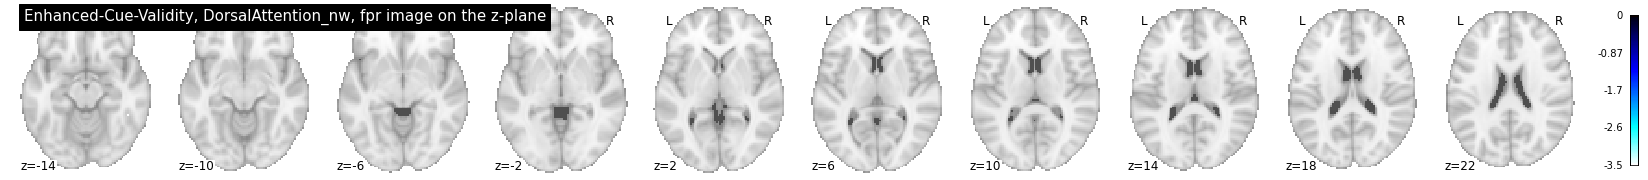

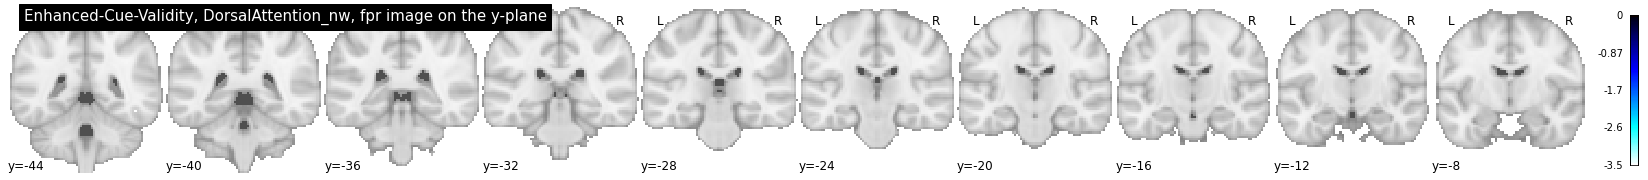

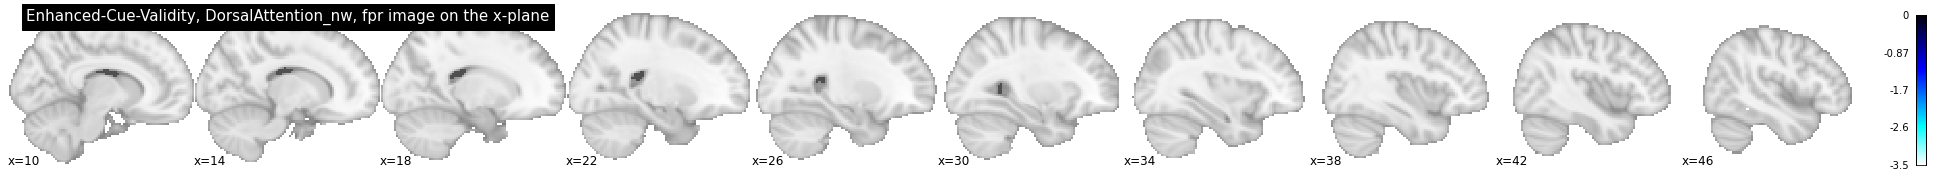

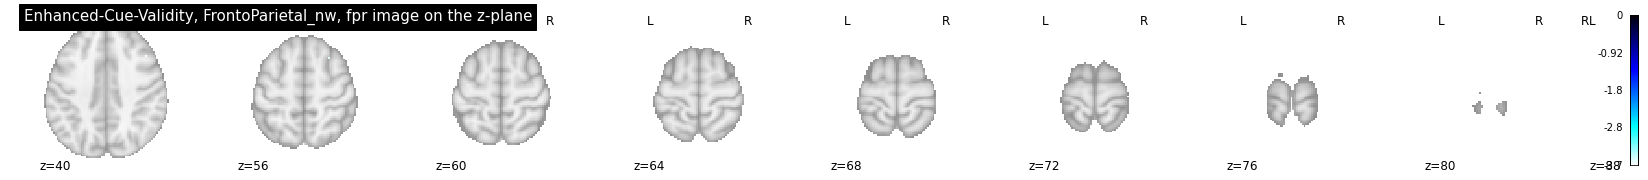

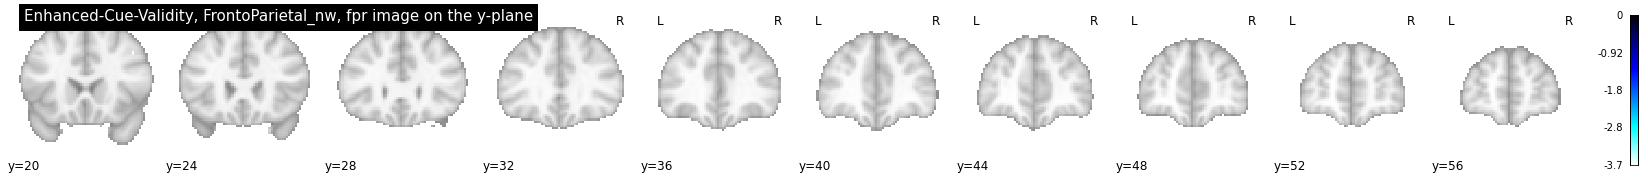

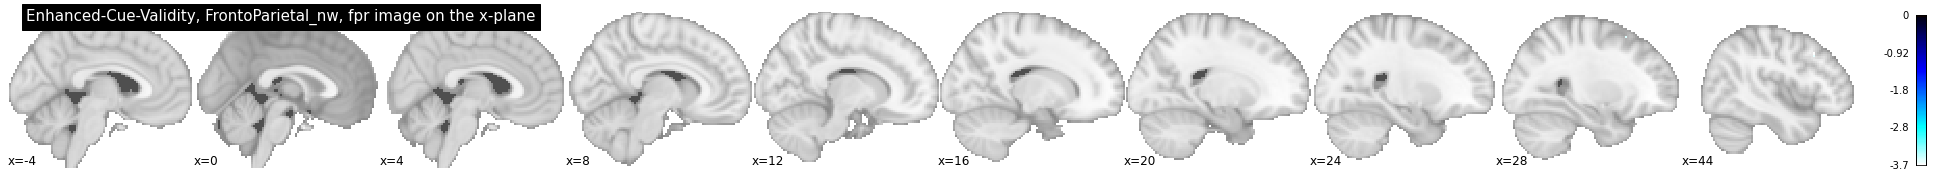

In [9]:
# plot results only for any non-empty contrast after thresholding
for contrast in stat_imgs_thresh.keys():
    for roi_tuple in stat_imgs_thresh[contrast]:
        for stat_img in roi_tuple[1]:
            stat_nb = nb.load(stat_img)
            # if there are any values above zero in the thresholded T-test z-stat image, create figures
            stat_nb_data = np.asanyarray(stat_nb.dataobj)
            if stat_nb_data[:, :, :][stat_nb_data[:, :, :] != 0].any():  # 1 and 2 sided tests!^^
                print(" Statistical image  ", stat_img, "  contains significant values.")
                print("Proceeding with figure creation ...")
                # create nilearn_plotting figures
                stat_img_3D_GM = ni_plt.view_img(stat_img, threshold = 0, cut_coords = [-42, -16, 52], title = "")
                stat_map_zslice10_GM = ni_plt.plot_stat_map(stat_img, threshold = 0, display_mode = "z", cut_coords = 10,
                                                            title = f"{contrast}, {roi_tuple[0]}, {stat_img.rsplit('/', 1)[1].split('_', 1)[0]} image on the z-plane")
                stat_map_xslice10_GM = ni_plt.plot_stat_map(stat_img, threshold = 0, display_mode = "y", cut_coords = 10,
                                                            title = f"{contrast}, {roi_tuple[0]}, {stat_img.rsplit('/', 1)[1].split('_', 1)[0]} image on the y-plane")
                stat_map_yslice10_GM = ni_plt.plot_stat_map(stat_img, threshold = 0, display_mode = "x", cut_coords = 10,
                                                            title = f"{contrast}, {roi_tuple[0]}, {stat_img.rsplit('/', 1)[1].split('_', 1)[0]} image on the x-plane")

                # save nilearn_plotting figures as HTML and PNGs
                stat_img_3D_GM.save_as_html(os.path.join(fMRI_group_dir,
                                                         f"{contrast}_{roi_tuple[0]}_{stat_img.rsplit('/', 1)[1].split('_', 1)[0]}_3Dimg.html"))
                stat_map_zslice10_GM.savefig(os.path.join(fMRI_group_dir,
                                                          f"{contrast}_{roi_tuple[0]}_{stat_img.rsplit('/', 1)[1].split('_', 1)[0]}_statmap_Zslice10.png"))
                stat_map_xslice10_GM.savefig(os.path.join(fMRI_group_dir,
                                                          f"{contrast}_{roi_tuple[0]}_{stat_img.rsplit('/', 1)[1].split('_', 1)[0]}_statmap_Xslice10.png"))
                stat_map_yslice10_GM.savefig(os.path.join(fMRI_group_dir,
                                                          f"{contrast}_{roi_tuple[0]}_{stat_img.rsplit('/', 1)[1].split('_', 1)[0]}_statmap_Yslice10.png"))

            # if only an empty image survived, skip it and go to the next one
            else:
                print("This image seems to be empty. Continuing with next image ...")

Testing Zone

Inspect possible error in model estimation (overfitting of error variance due to smoothness within the explicit nw_ROI masks)

In [93]:
# Inspect the residual meansquared (ResMS, error variance) images per model
res_ms = sorted([f"{fMRI_group_dir}{condir}/{maskdir}/ttest2S_modest/ResMS.nii"
                 for condir in os.listdir(fMRI_group_dir)
                 if os.path.isdir(f"{fMRI_group_dir}{condir}/")
                 for maskdir in os.listdir(f"{fMRI_group_dir}{condir}/")
                 # check that the target file actually exists
                 if os.path.exists(f"{fMRI_group_dir}{condir}/{maskdir}/ttest2S_modest/ResMS.nii")])

# collect groupmask files for networks that were estimable
group_masks = [f"{fMRI_template_dir}{mask}" for mask in os.listdir(fMRI_template_dir)
               if "_nw" in mask]  # Python uses: 1. __contains__(self, item) 2. __iter__(self) 3. __getitem__(self, key)

# select according to res_ms and sort by nw to visualise and compare
nw_masks = [mask for res in res_ms
            for mask in group_masks
            if mask.rsplit('/', 1)[1][:-13] in res]

In [94]:
for res, mask in zip(res_ms, nw_masks):
    print(f"{mask}    {res}")

/fMRI/MNI_templates/Salience_nw_group.nii    /fMRI/Grouplevel/dad1_NegI-NeuI/Salience_nw/ttest2S_modest/ResMS.nii
/fMRI/MNI_templates/VentralAttention_nw_group.nii    /fMRI/Grouplevel/dad1_NegI-NeuI/VentralAttention_nw/ttest2S_modest/ResMS.nii
/fMRI/MNI_templates/FrontoParietal_nw_group.nii    /fMRI/Grouplevel/dad2_PosI-NeuI/FrontoParietal_nw/ttest2S_modest/ResMS.nii
/fMRI/MNI_templates/DorsalAttention_nw_group.nii    /fMRI/Grouplevel/dadF_Difficulty-Attentional-Disengagement/DorsalAttention_nw/ttest2S_modest/ResMS.nii
/fMRI/MNI_templates/FrontoParietal_nw_group.nii    /fMRI/Grouplevel/dadF_Difficulty-Attentional-Disengagement/FrontoParietal_nw/ttest2S_modest/ResMS.nii
/fMRI/MNI_templates/Salience_nw_group.nii    /fMRI/Grouplevel/dadF_Difficulty-Attentional-Disengagement/Salience_nw/ttest2S_modest/ResMS.nii
/fMRI/MNI_templates/VentralAttention_nw_group.nii    /fMRI/Grouplevel/dadF_Difficulty-Attentional-Disengagement/VentralAttention_nw/ttest2S_modest/ResMS.nii
/fMRI/MNI_templates/Dors

In [96]:
# control number of ResMS files. Should be 11 (See "fMRI_2ndlevel.ipynb" for details)
print(res_ms)
print(len(res_ms))

# now the group mask files. Should be 4 (See "fMRI_2ndlevel.ipynb" for details)
print(group_masks)
print(len(group_masks))

# now the adapted nw mask files. Should be 11 (See "fMRI_2ndlevel.ipynb" for details)
print(nw_masks)
print(len(nw_masks))

['/fMRI/Grouplevel/dad1_NegI-NeuI/Salience_nw/ttest2S_modest/ResMS.nii', '/fMRI/Grouplevel/dad1_NegI-NeuI/VentralAttention_nw/ttest2S_modest/ResMS.nii', '/fMRI/Grouplevel/dad2_PosI-NeuI/FrontoParietal_nw/ttest2S_modest/ResMS.nii', '/fMRI/Grouplevel/dadF_Difficulty-Attentional-Disengagement/DorsalAttention_nw/ttest2S_modest/ResMS.nii', '/fMRI/Grouplevel/dadF_Difficulty-Attentional-Disengagement/FrontoParietal_nw/ttest2S_modest/ResMS.nii', '/fMRI/Grouplevel/dadF_Difficulty-Attentional-Disengagement/Salience_nw/ttest2S_modest/ResMS.nii', '/fMRI/Grouplevel/dadF_Difficulty-Attentional-Disengagement/VentralAttention_nw/ttest2S_modest/ResMS.nii', '/fMRI/Grouplevel/ecvF_Enhanced-Cue-Validity/DorsalAttention_nw/ttest2S_modest/ResMS.nii', '/fMRI/Grouplevel/ecvF_Enhanced-Cue-Validity/FrontoParietal_nw/ttest2S_modest/ResMS.nii', '/fMRI/Grouplevel/ecvF_Enhanced-Cue-Validity/Salience_nw/ttest2S_modest/ResMS.nii', '/fMRI/Grouplevel/ecvF_Enhanced-Cue-Validity/VentralAttention_nw/ttest2S_modest/ResMS.n

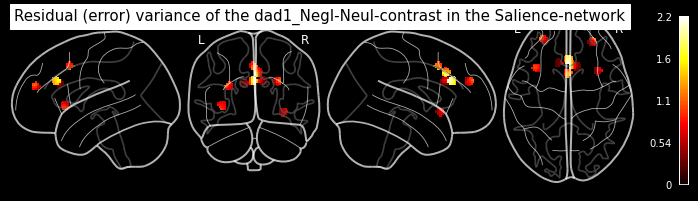

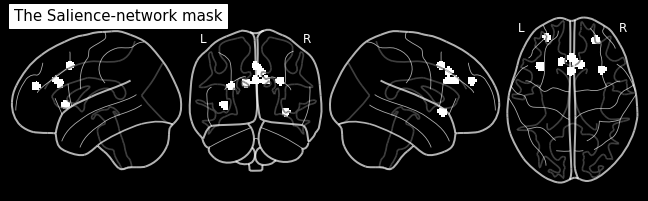

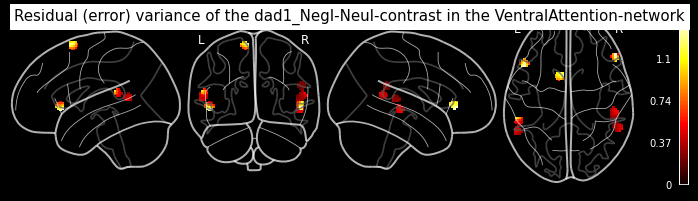

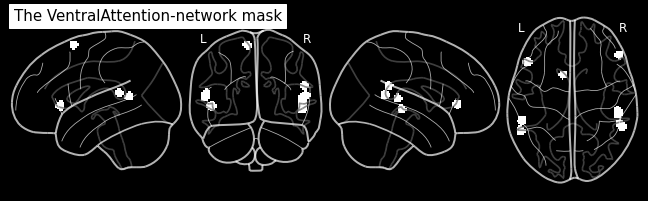

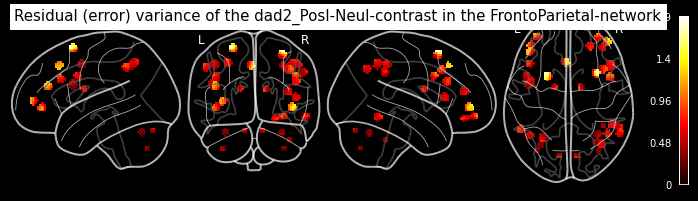

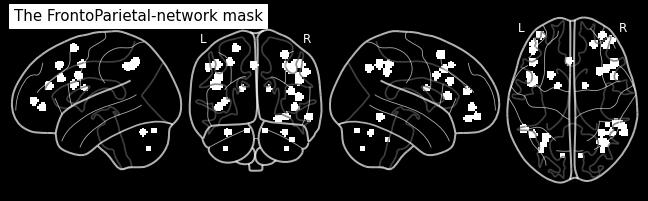

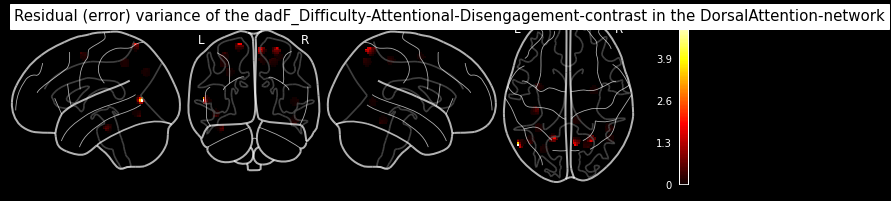

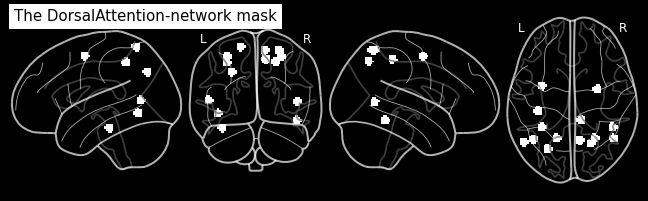

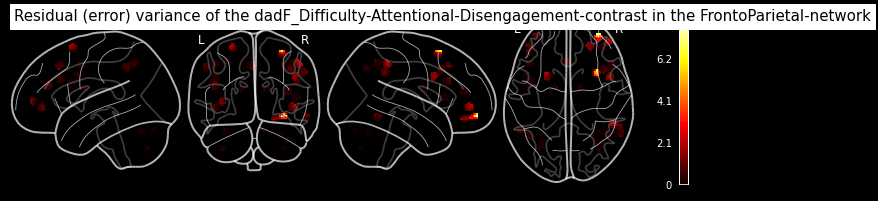

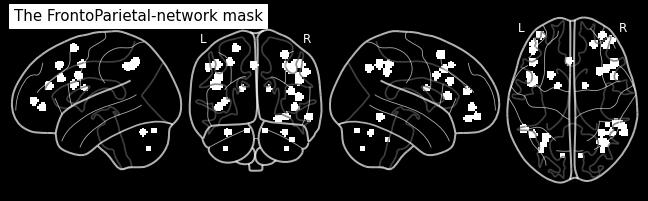

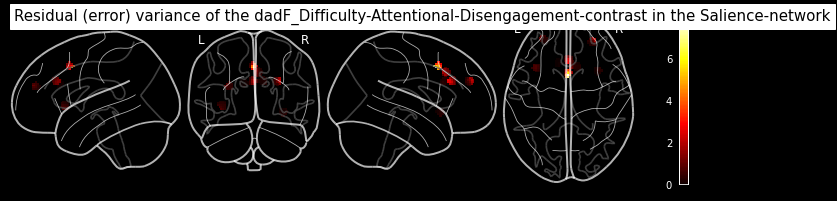

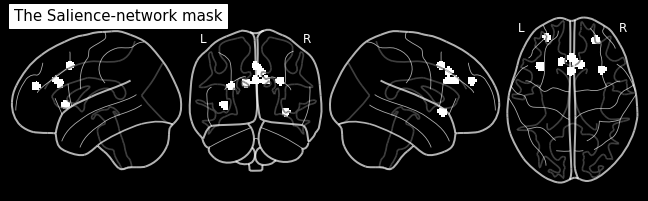

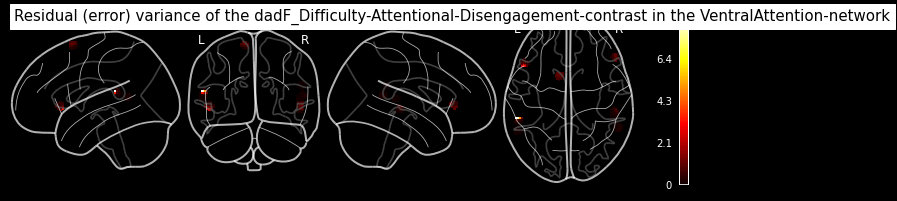

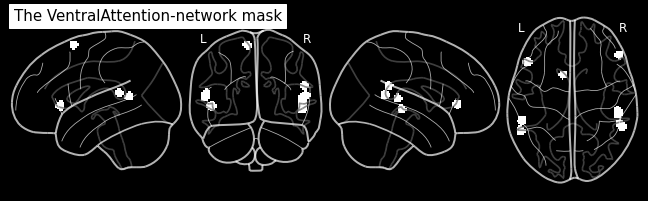

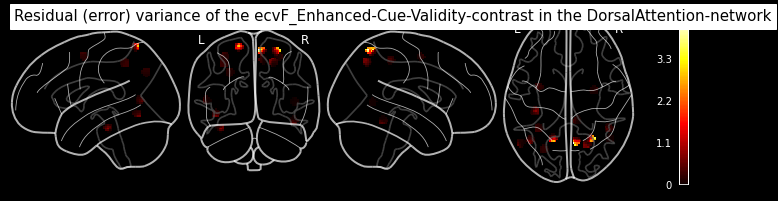

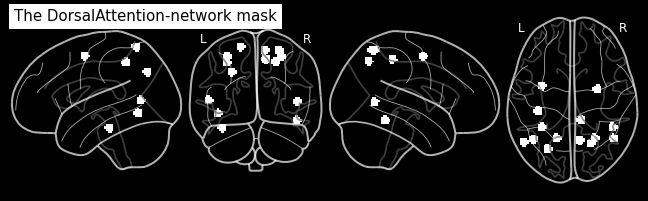

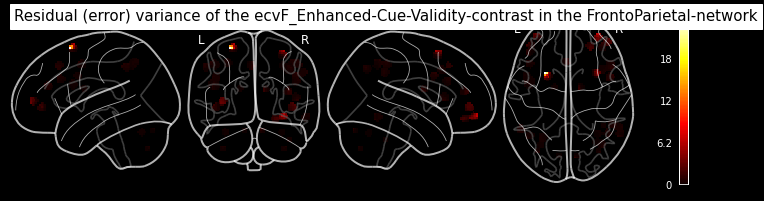

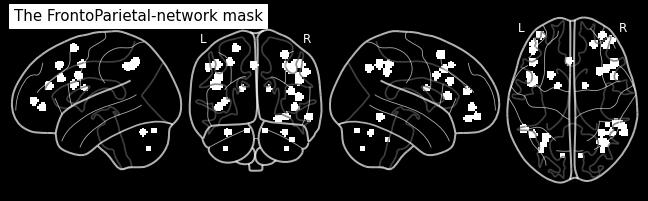

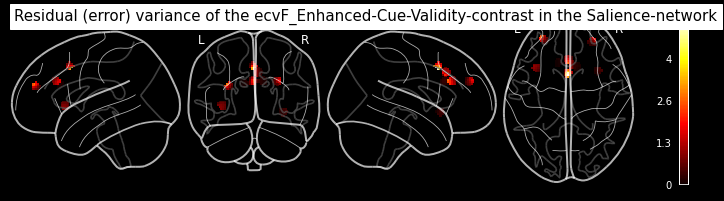

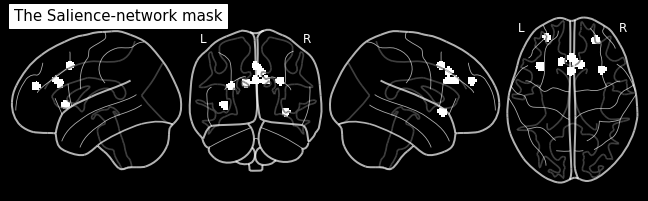

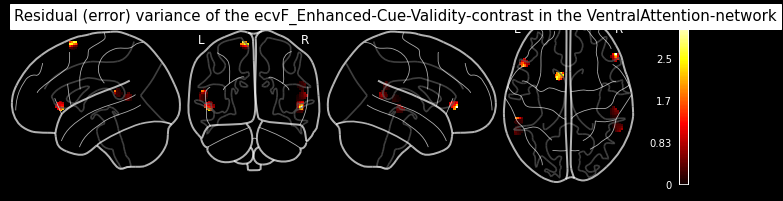

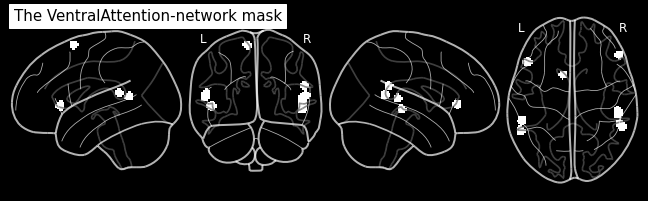

In [98]:
# plot res and nw onto a glass brain to see the 3D structure better
for res, mask in zip(res_ms, nw_masks):
    resglas = ni_plt.plot_glass_brain(res, colorbar=True, display_mode='lyrz', black_bg=True, threshold=0,
                                      title=f"Residual (error) variance of the {res.split('/', 4)[3]}-contrast in the {mask.rsplit('/', 1)[1][:-13]}-network");
    maskglas = ni_plt.plot_glass_brain(mask, colorbar=False, display_mode='lyrz', black_bg=True, threshold=0,
                                       title=f"The {mask.rsplit('/', 1)[1][:-13]}-network mask");
    # print the figure to the screen
    plt.show(resglas)
    plt.show(maskglas)
    # close the figure to prevent memory overload
    resglas.close()
    maskglas.close()

Inspect unthresholded group contrast images to assess the success of different thresholding techniques

In [12]:
# Inspect the un-thresholded statistical images per contrast and nw_mask
conests = sorted([f"{fMRI_group_dir}{condir}/{maskdir}/ttest2S_modest/MDDvsCON_conest/spmT_0001.nii"
                        for condir in os.listdir(fMRI_group_dir)
                        if os.path.isdir(f"{fMRI_group_dir}{condir}/")
                        for maskdir in os.listdir(f"{fMRI_group_dir}{condir}/")
                        # check that the target directory really exists
                        if os.path.isdir(f"{fMRI_group_dir}{condir}/{maskdir}/ttest2S_modest/MDDvsCON_conest/")])

In [13]:
# control number of contrast estimate directories. Should be 11 (See "fMRI_2ndlevel.ipynb" for details)
print(conest_dirs)
print(len(conest_dirs))

# now the contrast estimate files. Should be 11 (See "fMRI_2ndlevel.ipynb" for details)
print(conest_dirs)
print(len(conest_dirs))

['/fMRI/Grouplevel/dad1_NegI-NeuI/Salience_nw/ttest2S_modest/MDDvsCON_conest/spmT_0001.nii', '/fMRI/Grouplevel/dad1_NegI-NeuI/VentralAttention_nw/ttest2S_modest/MDDvsCON_conest/spmT_0001.nii', '/fMRI/Grouplevel/dad2_PosI-NeuI/FrontoParietal_nw/ttest2S_modest/MDDvsCON_conest/spmT_0001.nii', '/fMRI/Grouplevel/dadF_Difficulty-Attentional-Disengagement/DorsalAttention_nw/ttest2S_modest/MDDvsCON_conest/spmT_0001.nii', '/fMRI/Grouplevel/dadF_Difficulty-Attentional-Disengagement/FrontoParietal_nw/ttest2S_modest/MDDvsCON_conest/spmT_0001.nii', '/fMRI/Grouplevel/dadF_Difficulty-Attentional-Disengagement/Salience_nw/ttest2S_modest/MDDvsCON_conest/spmT_0001.nii', '/fMRI/Grouplevel/dadF_Difficulty-Attentional-Disengagement/VentralAttention_nw/ttest2S_modest/MDDvsCON_conest/spmT_0001.nii', '/fMRI/Grouplevel/ecvF_Enhanced-Cue-Validity/DorsalAttention_nw/ttest2S_modest/MDDvsCON_conest/spmT_0001.nii', '/fMRI/Grouplevel/ecvF_Enhanced-Cue-Validity/FrontoParietal_nw/ttest2S_modest/MDDvsCON_conest/spmT_00

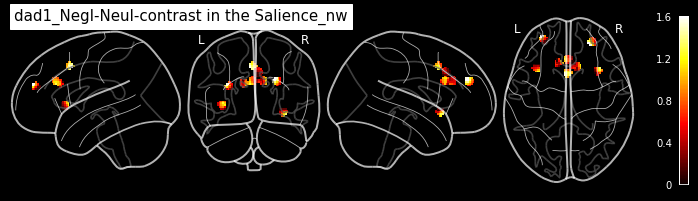

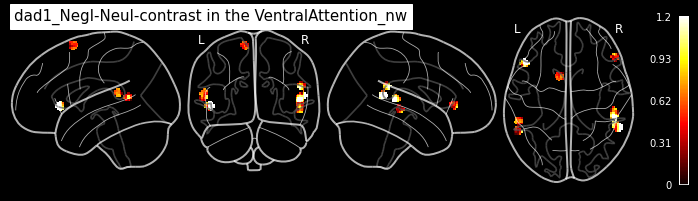

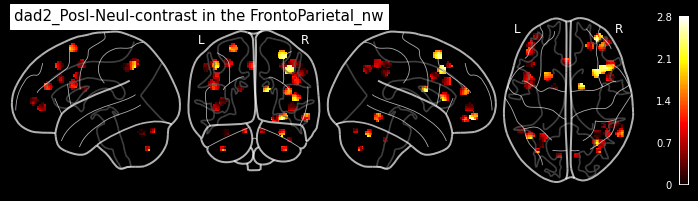

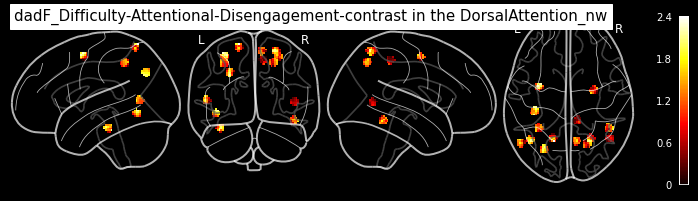

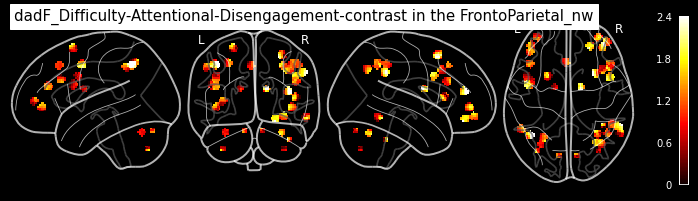

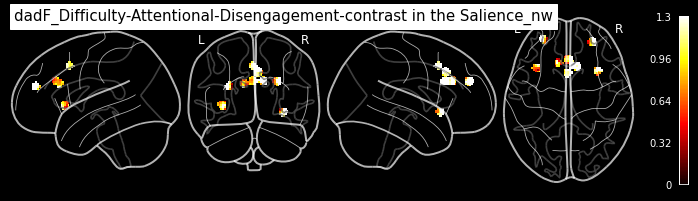

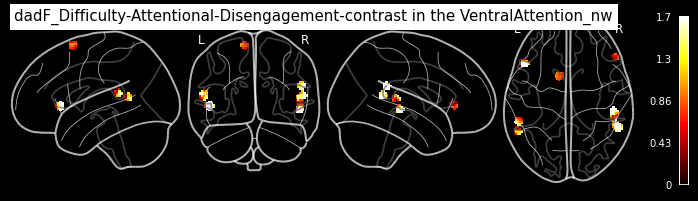

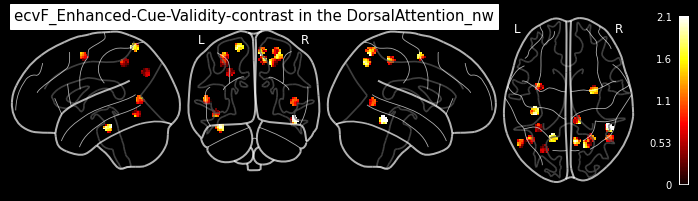

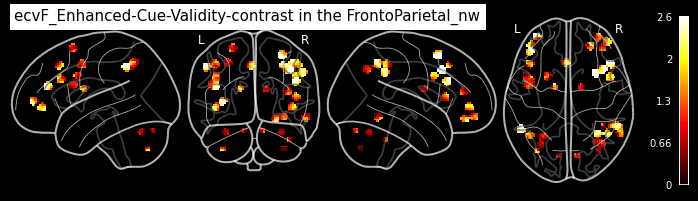

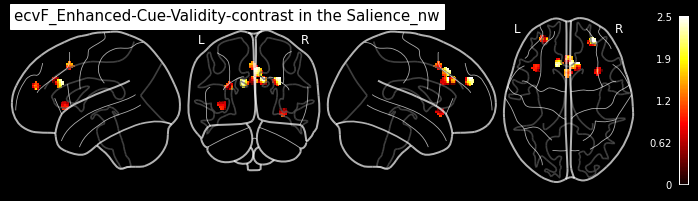

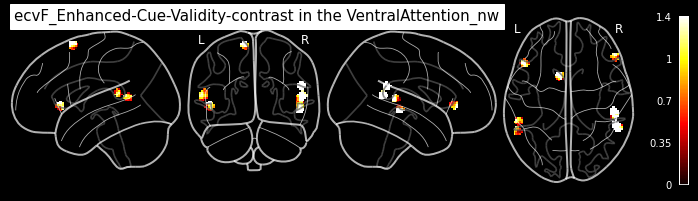

In [21]:
# plot them onto a glass brain to see the 3D structure better
for conest in conests:
    glassbrainplt = ni_plt.plot_glass_brain(conest, colorbar=True, display_mode='lyrz', black_bg=True, threshold=0,
                                                    title=f"{conest.split('/', 4)[3]}-contrast in the {conest.split('/', 5)[4]}");
    # print the figure to the screen
    plt.show(glassbrainplt)
    # close the figure to prevent memory overload
    glassbrainplt.close()

Collect contrast dirs and msk dirs as mask on grouplevel to create results tables

In [45]:
contrast_dirs = sorted([condir for condir in os.listdir(fMRI_group_dir)
                        if os.path.isdir(f"{fMRI_group_dir}/{condir}")], key = lambda x: (len(x), x[0], x.split('_', 1)[0][-1]))
mask_dirs = [[maskdir for maskdir in os.listdir(f"{fMRI_group_dir}/{condir}")]
             for condir in contrast_dirs]
# transpose mask_dirs to make it easier to dataframe
mask_dirs_t = list(map(list, zip(*mask_dirs)))

In [46]:
print(contrast_dirs)
print(mask_dirs_t)

['CV_F', 'DAD_F', 'CV_neg', 'CV_neu', 'CV_pos', 'DAD_pos', 'DAD_neg']
[['Frontal-Operculum-Cortex', 'Frontal-Operculum-Cortex', 'Frontal-Operculum-Cortex', 'Frontal-Operculum-Cortex', 'Frontal-Operculum-Cortex', 'Frontal-Operculum-Cortex', 'Frontal-Operculum-Cortex'], ['Superior-Frontal-Gyrus', 'Superior-Frontal-Gyrus', 'Superior-Frontal-Gyrus', 'Superior-Frontal-Gyrus', 'Superior-Frontal-Gyrus', 'Superior-Frontal-Gyrus', 'Superior-Frontal-Gyrus'], ['Middle-Frontal-Gyrus', 'Middle-Frontal-Gyrus', 'Middle-Frontal-Gyrus', 'Middle-Frontal-Gyrus', 'Middle-Frontal-Gyrus', 'Middle-Frontal-Gyrus', 'Middle-Frontal-Gyrus'], ['Hippocampus', 'Hippocampus', 'Hippocampus', 'Hippocampus', 'Hippocampus', 'Hippocampus', 'Hippocampus'], ['Frontal-Orbital-Cortex', 'Frontal-Orbital-Cortex', 'Frontal-Orbital-Cortex', 'Frontal-Orbital-Cortex', 'Frontal-Orbital-Cortex', 'Frontal-Orbital-Cortex', 'Frontal-Orbital-Cortex'], ['Inferior-Frontal-Gyrus-pars-triangularis', 'Inferior-Frontal-Gyrus-pars-triangularis

In [47]:
# transfer lists to structured dataframe
contrast_by_mask = pd.DataFrame(mask_dirs_t, columns = contrast_dirs)

In [48]:
# rename columns appropriately
contrast_by_mask_fin = contrast_by_mask.rename({'CV_neg':'Cue Validity (neg)', 'CV_pos':'Cue Validity (pos)', 'CV_neu':'Cue Validity (neu)',
                                                'DAD_neg':'Difficulty in Attentional Disengagement (neg)', 'DAD_pos':'Difficulty in Attentional Disengagement (pos)',
                                                'CV_F':'Cue Validity (F contrast)', 'DAD_F':'Difficulty in Attentional Disengagement (F contrast)'}, axis=1)

In [49]:
# inspect the frame
contrast_by_mask_fin

Cue Validity (F contrast)  \
0                   Frontal-Operculum-Cortex   
1                     Superior-Frontal-Gyrus   
2                       Middle-Frontal-Gyrus   
3                                Hippocampus   
4                     Frontal-Orbital-Cortex   
5   Inferior-Frontal-Gyrus-pars-triangularis   
6          Inferior-Temporal-Gyrus-posterior   
7                        VentralAttention_nw   
8                          FrontoParietal_nw   
9            Middle-Temporal-Gyrus-posterior   
10                             Full_ROI_mask   
11            Middle-Temporal-Gyrus-anterior   
12            Parahippocampal-Gyrus-anterior   
13          Inferior-Temporal-Gyrus-anterior   
14                            Insular-Cortex   
15                               Salience_nw   
16           Parahippocampal-Gyrus-posterior   
17                             Temporal-Pole   
18         Superior-Temporal-Gyrus-posterior   
19                  Cingulate-Gyrus-anterior   
20          Superior-Temporal-Gyrus-anterior   
21                        DorsalAttention_nw   
22                                  Amygdala   
23                       Paracingulate-Gyrus   
24                              Frontal-Pole   
25   Inferior-Frontal-Gyrus-pars-opercularis   

   Difficulty in Attentional Disengagement (F contrast)  \
0                            Frontal-Operculum-Cortex     
1                              Superior-Frontal-Gyrus     
2                                Middle-Frontal-Gyrus     
3                                         Hippocampus     
4                              Frontal-Orbital-Cortex     
5            Inferior-Frontal-Gyrus-pars-triangularis     
6                   Inferior-Temporal-Gyrus-posterior     
7                                 VentralAttention_nw     
8                                   FrontoParietal_nw     
9                     Middle-Temporal-Gyrus-posterior     
10                                      Full_ROI_mask     
11                     Middle-Temporal-Gyrus-anterior     
12                     Parahippocampal-Gyrus-anterior     
13                   Inferior-Temporal-Gyrus-anterior     
14                                     Insular-Cortex     
15                                        Salience_nw     
16                    Parahippocampal-Gyrus-posterior     
17                                      Temporal-Pole     
18                  Superior-Temporal-Gyrus-posterior     
19                           Cingulate-Gyrus-anterior     
20                   Superior-Temporal-Gyrus-anterior     
21                                 DorsalAttention_nw     
22                                           Amygdala     
23                                Paracingulate-Gyrus     
24                                       Frontal-Pole     
25            Inferior-Frontal-Gyrus-pars-opercularis     

                          Cue Validity (neg)  \
0                   Frontal-Operculum-Cortex   
1                     Superior-Frontal-Gyrus   
2                       Middle-Frontal-Gyrus   
3                                Hippocampus   
4                     Frontal-Orbital-Cortex   
5   Inferior-Frontal-Gyrus-pars-triangularis   
6          Inferior-Temporal-Gyrus-posterior   
7                        VentralAttention_nw   
8                          FrontoParietal_nw   
9            Middle-Temporal-Gyrus-posterior   
10                             Full_ROI_mask   
11            Middle-Temporal-Gyrus-anterior   
12            Parahippocampal-Gyrus-anterior   
13          Inferior-Temporal-Gyrus-anterior   
14                            Insular-Cortex   
15                               Salience_nw   
16           Parahippocampal-Gyrus-posterior   
17                             Temporal-Pole   
18         Superior-Temporal-Gyrus-posterior   
19                  Cingulate-Gyrus-anterior   
20          Superior-Temporal-Gyrus-anterior   
21                        DorsalAttention_nw   
22                      

In [50]:
# split full frame by variable and contrast type
cv_t = contrast_by_mask_fin.iloc[:, 2:5]
dad_t = contrast_by_mask_fin.iloc[:, 5:]
# switch columns in dad_t
dad_t = dad_t[dad_t.columns[::-1]]
F = contrast_by_mask_fin.iloc[:, 0:2]

In [52]:
# inspect split frames
dad_t

Difficulty in Attentional Disengagement (neg)  \
0                       Frontal-Operculum-Cortex   
1                         Superior-Frontal-Gyrus   
2                           Middle-Frontal-Gyrus   
3                                    Hippocampus   
4                         Frontal-Orbital-Cortex   
5       Inferior-Frontal-Gyrus-pars-triangularis   
6              Inferior-Temporal-Gyrus-posterior   
7                            VentralAttention_nw   
8                              FrontoParietal_nw   
9                Middle-Temporal-Gyrus-posterior   
10                                 Full_ROI_mask   
11                Middle-Temporal-Gyrus-anterior   
12                Parahippocampal-Gyrus-anterior   
13              Inferior-Temporal-Gyrus-anterior   
14                                Insular-Cortex   
15                                   Salience_nw   
16               Parahippocampal-Gyrus-posterior   
17                                 Temporal-Pole   
18             Superior-Temporal-Gyrus-posterior   
19                      Cingulate-Gyrus-anterior   
20              Superior-Temporal-Gyrus-anterior   
21                            DorsalAttention_nw   
22                                      Amygdala   
23                           Paracingulate-Gyrus   
24                                  Frontal-Pole   
25       Inferior-Frontal-Gyrus-pars-opercularis   

   Difficulty in Attentional Disengagement (pos)  
0                       Frontal-Operculum-Cortex  
1                         Superior-Frontal-Gyrus  
2                           Middle-Frontal-Gyrus  
3                                    Hippocampus  
4                         Frontal-Orbital-Cortex  
5       Inferior-Frontal-Gyrus-pars-triangularis  
6              Inferior-Temporal-Gyrus-posterior  
7                            VentralAttention_nw  
8                              FrontoParietal_nw  
9                Middle-Temporal-Gyrus-posterior  
10                                 Full_ROI_mask  
11                Middle-Temporal-Gyrus-anterior  
12                Parahippocampal-Gyrus-anterior  
13              Inferior-Temporal-Gyrus-anterior  
14                                Insular-Cortex  
15                                   Salience_nw  
16               Parahippocampal-Gyrus-posterior  
17                                 Temporal-Pole  
18             Superior-Temporal-Gyrus-posterior  
19                      Cingulate-Gyrus-anterior  
20              Superior-Temporal-Gyrus-anterior  
21                            DorsalAttention_nw  
22                                      Amygdala  
23                           Paracingulate-Gyrus  
24                                  Frontal-Pole  
25       Inferior-Frontal-Gyrus-pars-opercularis

In [53]:
# restrict each split frame to show only the contrasts whose models estimated successfully
# copy our frames to be able to compare later
cv_t_succ, dad_t_succ, F_succ = cv_t.copy(), dad_t.copy(), F.copy()
# list to collect all significant contrasts and masks
con_mask_list = [[], []]
for thresh_succ in threshcon_dirs:
    # extract contrast and mask IDs
    con = thresh_succ.split('/', 5)[3]
    masks = [mask.split('/', 5)[4] for mask in threshcon_dirs
             if re.match(fr'.*{con}.*', mask)]
    # append to con_mask_list
    con_mask_list[0].append(con)
    con_mask_list[1].append(masks)

In [54]:
# make finished list into a dataframe
# fill all mask lists with NaNs up to have the same length
max_len = np.max([len(ls) for ls in con_mask_list[1]])
for ls in con_mask_list[1]:
    while len(ls) < max_len:
        ls.append(None)
        print("Padding with None until same length for all ...")
    if len(np.unique([len(ls) for ls in con_mask_list[1]])) == 1:
        break
# return final statement
print("Loop terminated. All lists should be equally long now.")

# transpose mask lists to make them easier to dataframe
con_mask_list[1] = list(map(list, zip(*con_mask_list[1])))
# convert nested list to dataframe
con_mas_succ = pd.DataFrame(con_mask_list[1], columns = con_mask_list[0])
# drop identical columns
con_mas_succ = con_mas_succ.loc[:, ~con_mas_succ.columns.duplicated()]  # '~' flips the returned boolean array, as we want to keep the UN-duplicated columns
# re-order columns
con_mas_succ = con_mas_succ.iloc[:, [2, 3, 0, 1]]
# rename columns appropriately
con_mas_succ_fin = con_mas_succ.rename({'DAD_neg':'DAD (neg)', 'DAD_pos':'DAD (pos)',
                                                'CV_F':'CV (F contrast)', 'DAD_F':'DAD (F contrast)'}, axis=1)

Padding with None until same length for all ...
Padding with None until same length for all ...
Padding with None until same length for all ...
Padding with None until same length for all ...
Padding with None until same length for all ...
Padding with None until same length for all ...
Padding with None until same length for all ...
Loop terminated. All lists should be equally long now.


In [55]:
con_mas_succ_fin

DAD (neg)          DAD (pos)      CV (F contrast)  \
0          Salience_nw  FrontoParietal_nw   DorsalAttention_nw   
1  VentralAttention_nw               None    FrontoParietal_nw   
2                 None               None          Salience_nw   
3                 None               None  VentralAttention_nw   

      DAD (F contrast)  
0   DorsalAttention_nw  
1    FrontoParietal_nw  
2          Salience_nw  
3  VentralAttention_nw

In [56]:
# full list of table plotting formats in pingouin:
# "plain" "simple" "github""grid" "fancy_grid" "pipe""orgtbl" "jira""presto" "pretty""psql" "rst" "mediawiki" "moinmoin" "youtrack" "html" "unsafehtml" "latex"
# "latex_raw" "latex_booktabs" "latex_longtable" "textile""tsv"
print_table(cv_t, tablefmt="latex")
print_table(dad_t, tablefmt="latex")
print_table(F, tablefmt="latex")
print_table(con_mas_succ_fin, tablefmt="latex")

\begin{tabular}{lll}
\hline
 Cue Validity (neg)                       & Cue Validity (neu)                       & Cue Validity (pos)                       \\
\hline
 Frontal-Operculum-Cortex                 & Frontal-Operculum-Cortex                 & Frontal-Operculum-Cortex                 \\
 Superior-Frontal-Gyrus                   & Superior-Frontal-Gyrus                   & Superior-Frontal-Gyrus                   \\
 Middle-Frontal-Gyrus                     & Middle-Frontal-Gyrus                     & Middle-Frontal-Gyrus                     \\
 Hippocampus                              & Hippocampus                              & Hippocampus                              \\
 Frontal-Orbital-Cortex                   & Frontal-Orbital-Cortex                   & Frontal-Orbital-Cortex                   \\
 Inferior-Frontal-Gyrus-pars-triangularis & Inferior-Frontal-Gyrus-pars-triangularis & Inferior-Frontal-Gyrus-pars-triangularis \\
 Inferior-Temporal-Gyrus-posterior        & Infe

Use the threshcon_dirs to find the report file for the contrast thresholding and extract the relevant parameters for each estimated contrast

In [12]:
# go through the resulting pklz file and collect the required parameters
test_succ_ls = []
for conthresh in threshcon_dirs:
    clus_results = loadpkl(f"{conthresh}result_FDR_thresh.pklz")
    vox_results = [file for file in os.listdir(conthresh)
                   if re.match(r'.*_zmap.*.nii', file)]
    # print parameters
    contrast = clus_results.outputs.pre_topo_fdr_map.split('/', 5)[3]
    mask = clus_results.outputs.pre_topo_fdr_map.split('/', 5)[4]
    extend_p = clus_results.inputs["extent_fdr_p_threshold"]
    extend_v = clus_results.inputs["extent_threshold"]
    hight_p = clus_results.inputs["height_threshold"]
    cluster_forming_t = clus_results.outputs.cluster_forming_thr
    voxel_t_fpr = [tfile.rsplit('_', 2)[1] for tfile in vox_results
                   if tfile.startswith("fpr")]
    voxel_t_fdr = [tfile.rsplit('_', 2)[1] for tfile in vox_results
                   if tfile.startswith("fdr")]
    voxel_t_fwer = [tfile.rsplit('_', 2)[1] for tfile in vox_results
                    if tfile.startswith("fwer")]

    # put all into list
    stats_params = [contrast, ["network mask", "false-positive correction method", "t(cluster-forming/voxel-based)", "p_height", "p_extend", "voxel_extend"],
                              [[mask, f"Cluster-based (topological) FDR correction using RFT", cluster_forming_t, hight_p, extend_p, extend_v]]]
    # add parameters for voxel-based corrections
    # for F tests
    if contrast[3] == "F":
        for ls in [[None, f"Voxel-based FPR adjustment(“uncorrected”)", *voxel_t_fpr, 0.0005],
                   [None, f"Voxel-based FDR correction", *voxel_t_fdr, 0.05],
                   [None, f"Voxel-based FWER correction", *voxel_t_fwer, 0.05]]:
            stats_params[2].append(ls)
    # for t tests
    else:
        for ls in [[None, f"Voxel-based FPR adjustment(“uncorrected”)", *voxel_t_fpr, 0.001],
                   [None, f"Voxel-based FDR correction", *voxel_t_fdr, 0.05],
                   [None, f"Voxel-based FWER correction", *voxel_t_fwer, 0.05]]:
            stats_params[2].append(ls)
    # make data into dataframe
    stats_params_df = pd.DataFrame.from_records(stats_params[2], columns = stats_params[1])
    # fill with None instead of NaN
    stats_params_df = stats_params_df.where(stats_params_df.notnull(), None)
    # append this to the final test list together with contrast as ID
    test_succ_ls.append([contrast, stats_params_df])

In [13]:
# collect equal contrast across all network masks
d = defaultdict(list)
for contrast, frame in test_succ_ls:
    d[contrast].append(frame)
test_succ_ls = list([[*item] for item in d.items()])  # unpacking tuples is a blessing!^^

# concatenate the dataframes for the same contrast
for contrast in test_succ_ls:
    contrast[1] = pd.concat(contrast[1])

In [14]:
# control the endresult
for contrast in test_succ_ls[0:1]:
    print(contrast[1])

          network mask                   false-positive correction method  \
0          Salience_nw  Cluster-based (topological) FDR correction usi...   
1                 None          Voxel-based FPR adjustment(“uncorrected”)   
2                 None                         Voxel-based FDR correction   
3                 None                        Voxel-based FWER correction   
0  VentralAttention_nw  Cluster-based (topological) FDR correction usi...   
1                 None          Voxel-based FPR adjustment(“uncorrected”)   
2                 None                         Voxel-based FDR correction   
3                 None                        Voxel-based FWER correction   

  t(cluster-forming/voxel-based) p_height p_extend voxel_extend  
0                        3.23421    0.001     0.05            4  
1              3.090232306167813    0.001     None         None  
2                            inf     0.05     None         None  
3              3.769360853235867     0.05 

In [235]:
# bring all contrast dataframes together into one
test_succ_findata = pd.concat([contrast[1] for contrast in test_succ_ls])

In [236]:
test_succ_findata

contrast         network mask  \
0                             dad1_NegI-NeuI          Salience_nw   
0                                             VentralAttention_nw   
0                             dad2_PosI-NeuI    FrontoParietal_nw   
0  dadF_Difficulty-Attentional-Disengagement   DorsalAttention_nw   
0                                               FrontoParietal_nw   
0                                                     Salience_nw   
0                                             VentralAttention_nw   
0                 ecvF_Enhanced-Cue-Validity   DorsalAttention_nw   
0                                               FrontoParietal_nw   
0                                                     Salience_nw   
0                                             VentralAttention_nw   

                    false-positive correction method t_cluster-forming  \
0  Cluster-based (topological) FDR correction usi...           3.23421   
0  Cluster-based (topological) FDR correction usi...           3.23421   
0  Cluster-based (topological) FDR correction usi...           3.23421   
0  Cluster-based (topological) FDR correction usi...           3.23421   
0  Cluster-based (topological) FDR correction usi...           3.23421   
0  Cluster-based (topological) FDR correction usi...           3.23421   
0  Cluster-based (topological) FDR correction usi...           3.23421   
0  Cluster-based (topological) FDR correction usi...           3.23421   
0  Cluster-based (topological) FDR correction usi...           3.23421   
0  Cluster-based (topological) FDR correction usi...           3.23421   
0  Cluster-based (topological) FDR correction usi...           3.23421   

  p_height p_extend voxel_extend  
0    0.001     0.05            4  
0    0.001     0.05            4  
0    0.001     0.05            4  
0    0.001     0.05            4  
0    0.001     0.05            4  
0    0.001     0.05            4  
0    0.001     0.05            4  
0    0.001     0.05            4  
0    0.001     0.05            4  
0    0.001     0.05            4  
0    0.001     0.05            4

In [15]:
# full list of table plotting formats in pingouin:
# "plain" "simple" "github""grid" "fancy_grid" "pipe""orgtbl" "jira""presto" "pretty""psql" "rst" "mediawiki" "moinmoin" "youtrack" "html" "unsafehtml" "latex"
# "latex_raw" "latex_booktabs" "latex_longtable" "textile""tsv"
for contrast in test_succ_ls:
    print(contrast[0])
    print_table(contrast[1], tablefmt="latex", floatfmt=".4f")

dad1_NegI-NeuI
\begin{tabular}{llrrrr}
\hline
 network mask        & false-positive correction method                     &   t(cluster-forming/voxel-based) &   p\_height &   p\_extend &   voxel\_extend \\
\hline
 Salience\_nw         & Cluster-based (topological) FDR correction using RFT &                           3.2342 &     0.0010 &     0.0500 &         4.0000 \\
                     & Voxel-based FPR adjustment(“uncorrected”)            &                           3.0902 &     0.0010 &            &                \\
                     & Voxel-based FDR correction                           &                         inf      &     0.0500 &            &                \\
                     & Voxel-based FWER correction                          &                           3.7694 &     0.0500 &            &                \\
 VentralAttention\_nw & Cluster-based (topological) FDR correction using RFT &                           3.2342 &     0.0010 &     0.0500 &         4.0000 \\
